# Lagrangian Jacobian optimization

## Import statements

In [39]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up A $\phi$ = B case
Set up an example A*$\phi$ = B problem where there are negative Jacobian determinant values

In [37]:
# Create some example correspondence points
msample = np.array([  # Moving points
    [0, 0, 1],
    [0, 2, 1],
    [0, 2, 0],
])
fsample = np.array([  # Fixed points
    [0, 0, 2],
    [0, 2, 2],
    [0, 1, 1],
])
fixed_sample = np.zeros((1, 3, 3))  # Size of the fixed image

#############################################################################

# Create a Laplacian matrix from the sample set of correspondence points
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
Adense = A.toarray()

z, y, x = (0, 1, 1)  # Preview test index
laplacian_idx = laplacian.get_laplacian_index(z, y, x, fixed_sample.shape)

# Visualize values
print()
print("A shape:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(Adense))
print("A:")
print(Adense)
print()
print("Xd:", Xd)
print("Yd:", Yd)
print()

# Solving for Xd Yd
phi_x = lgmres(A, Xd, tol = 1e-2)[0]
print("phi_x:", phi_x)
phi_y = lgmres(A, Yd, tol = 1e-2)[0]
print("phi_y:", phi_y)

# Create expanded matrix to cover Xd and Yd
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [Adense, A0],
    [A0, Adense]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]

print()
print("A_expanded shape:", A_expanded.shape)
print("Rank of A_expanded:", np.linalg.matrix_rank(A_expanded))
print(A_expanded)
print("XYd:", XYd)
print("phi_xy:", phi_xy)
print()

fdata.shape (1, 3, 3)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.15438485145568848s
Computing dy
dy calculated in 0.15483474731445312s
Computing dx
dx calculated in 0.1551816463470459s

A shape: (9, 9)
Rank of A: 9
A:
[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  3. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  3.  0.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  2. -1.  0.]
 [ 0.  0.  0.  0. -1.  0. -1.  3. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]

Xd: [ 0.  0. -1.  0. -1.  0.  0.  0. -1.]
Yd: [0. 0. 0. 0. 1. 0. 0. 0. 0.]

phi_x: [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
phi_y: [0.66666667 0.55555556 0.         0.77777778 1.         0.33333333 0.66666667 0.55555556 0.        ]

A_expanded shape: (18, 18)
Rank of A_expanded: 18
[[ 2. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. 

/tmp/ipykernel_565135/2165156065.py:35: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_x = lgmres(A, Xd, tol = 1e-2)[0]
/tmp/ipykernel_565135/2165156065.py:37: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_y = lgmres(A, Yd, tol = 1e-2)[0]
/tmp/ipykernel_565135/2165156065.py:47: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


In [13]:
z, y, x = (0, 0, 0) 
print("Current index:", laplacian.get_laplacian_index(z, y, x, fixed_sample.shape))
print("Adjacent indices:", laplacian.get_adjacent_indices(z, y, x, fixed_sample.shape))

Current index: 0
Adjacent indices: [None, 1, None, 3]


In [14]:
def dxx(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta x(x + 1, y, z) - delta x(x - 1, y, z) / 2
    if x == 0:  # Left edge
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (right_x - curr_x) / 2
    elif x == shape[2] - 1:  # Right edge
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (curr_x - left_x) / 2
    else:
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        return (right_x - left_x) / 2


def dyy(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta y(x, y + 1, z) - delta y(x, y - 1, z) / 2
    if y == 0:  # Top edge
        down_y = phi[laplacian.get_laplacian_index(z, y + 1, x, shape) + len(phi) // 2]
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        return (down_y - curr_y) / 2
    elif y == shape[1] - 1:  # Bottom edge
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        up_y = phi[laplacian.get_laplacian_index(z, y - 1, x, shape) + len(phi) // 2]
        return (curr_y - up_y) / 2
    else:
        down_y = phi[laplacian.get_laplacian_index(z, y + 1, x, shape) + len(phi) // 2]
        up_y = phi[laplacian.get_laplacian_index(z, y - 1, x, shape) + len(phi) // 2]
        return (down_y - up_y) / 2


def dxy(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta x (x, y + 1, z) - delta x (x, y - 1, z) / 2
    if y == 0:  # Top edge
        down_x = phi[laplacian.get_laplacian_index(z, y + 1, x, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (down_x - curr_x) / 2
    elif y == shape[1] - 1:  # Bottom edge
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        up_x = phi[laplacian.get_laplacian_index(z, y - 1, x, shape)]
        return (curr_x - up_x) / 2
    else:
        down_x = phi[laplacian.get_laplacian_index(z, y + 1, x, shape)]
        up_x = phi[laplacian.get_laplacian_index(z, y - 1, x, shape)]
        return (down_x - up_x) / 2


def dyx(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta y (x + 1, y, z) - delta y (x - 1, y, z) / 2
    if x == 0:  # Left edge
        right_y = phi[laplacian.get_laplacian_index(z, y, x + 1, shape) + len(phi) // 2]
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        return (right_y - curr_y) / 2
    elif x == shape[2] - 1:  # Right edge
        curr_y = phi[laplacian.get_laplacian_index(z, y, x, shape) + len(phi) // 2]
        left_y = phi[laplacian.get_laplacian_index(z, y, x - 1, shape) + len(phi) // 2]
        return (curr_y - left_y) / 2
    else:
        right_y = phi[laplacian.get_laplacian_index(z, y, x + 1, shape) + len(phi) // 2]
        left_y = phi[laplacian.get_laplacian_index(z, y, x - 1, shape) + len(phi) // 2]
        return (right_y - left_y) / 2


def jdet(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    return (dxx(z, y, x, phi, shape) + 1) * (dyy(z, y, x, phi, shape) + 1) - dxy(z, y, x, phi, shape) * dyx(z, y, x, phi, shape)


Try a bigger image

fdata.shape (2, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 0.16461825370788574s
Computing dy
dy calculated in 0.16466617584228516s
Computing dx
dx calculated in 0.16557979583740234s
A shape: (50, 50)
[[ 3. -1.  0. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1.  0.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ...  0. -1.  3.]]
Rank of A: 50
Yd shape: (50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (50,)
[ 0.  0. -1.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Deformation shape: (3, 2, 5, 5)
Deformation:
[[[[ 0.          0.          0.          0.          0.        ]
   [ 0.          0.       

/tmp/ipykernel_565135/3486749312.py:40: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]


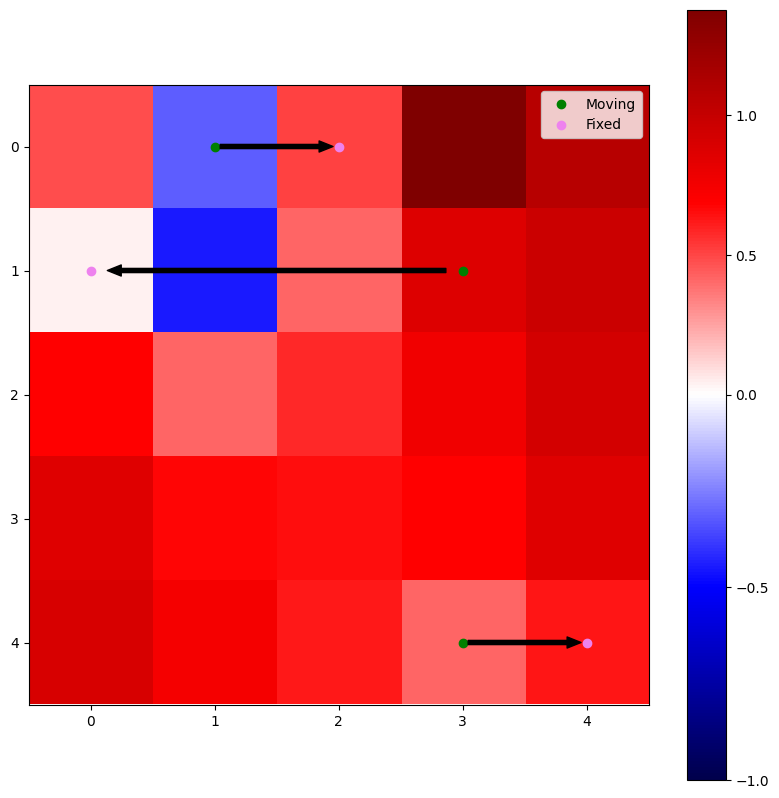

In [54]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 3],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 0],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((2, 5, 5))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))
A_expanded = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
XYd = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_expanded, XYd, tol = 1e-2)[0]

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()

for i in range(len(msample)):  # Draw lines connecting the points
    #plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='black', alpha=1)
    plt.annotate(
        '', 
        xy=(fsample[i][2], fsample[i][1]), 
        xytext=(msample[i][2], msample[i][1]), 
        arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
    )
    
plt.scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
plt.scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
plt.legend()
plt.show()

In [43]:
l_idx = laplacian.get_laplacian_index(0, 1, 1, fixed_sample.shape)
print(l_idx)

6


## Set up Lagrangian optimizer

In [15]:
import sympy as sp

def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

def jacobian_constraint(idx, idx_adj, phi_symbols):
    # (dxx + 1) * (dyy + 1) - dxy * dyx
    y_offset = len(phi_symbols) // 2
    adj_idx = idx_adj[idx]
    dxx = (phi_symbols[adj_idx[1]] - phi_symbols[adj_idx[0]]) / 2
    dyy = (phi_symbols[adj_idx[3] + y_offset] - phi_symbols[adj_idx[2] + y_offset]) / 2
    #  delta x (x, y + 1, z) - delta x (x, y - 1, z) / 2
    dxy = (phi_symbols[adj_idx[3]] - phi_symbols[adj_idx[2]]) / 2
    dyx = (phi_symbols[adj_idx[1] + y_offset] - phi_symbols[adj_idx[0] + y_offset]) / 2
    return (dxx + 1) * (dyy + 1) - (dxy * dyx)

Scipy minimizer

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustconstr.html

In [84]:
laplacian.get_laplacian_index(0, 0, 1, fixed_sample.shape)

1

In [128]:
import numpy as np
from scipy.optimize import minimize

# Define the matrix A and vector B
A_ = A_expanded
b_ = XYd

# Define the objective function
def objective(phi):
    return np.linalg.norm(A_ @ phi - b_)**2


def jacobian_constraint(idx, idx_adj, phi_symbols):
    # (dxx + 1) * (dyy + 1) - dxy * dyx
    y_offset = len(phi_symbols) // 2
    adj_idx = idx_adj[idx]
    dxx = (phi_symbols[adj_idx[1]] - phi_symbols[adj_idx[0]]) / 2
    dyy = (phi_symbols[adj_idx[3] + y_offset] - phi_symbols[adj_idx[2] + y_offset]) / 2
    #  delta x (x, y + 1, z) - delta x (x, y - 1, z) / 2
    dxy = (phi_symbols[adj_idx[3]] - phi_symbols[adj_idx[2]]) / 2
    dyx = (phi_symbols[adj_idx[1] + y_offset] - phi_symbols[adj_idx[0] + y_offset]) / 2
    return (dxx + 1) * (dyy + 1) - (dxy * dyx)

y_offset = len(b_) // 2
curr_idx = 6
idx_adj = idx_adjacency(fixed_sample.shape)
print(len(b_))

#jdet = ((phi_xy[right_idx] - phi_xy[left_idx]) / 2 + 1) * ((phi_xy[down_idx + y_offset] - phi_xy[up_idx + y_offset]) / 2 + 1) \
#                                      - ((phi_xy[down_idx] - phi_xy[up_idx]) / 2) * ((phi_xy[right_idx + y_offset] - phi_xy[left_idx + y_offset]) / 2)
#print(jdet)

def dxx(z: int, y: int, x: int, phi: np.ndarray, shape: tuple):
    # delta x(x + 1, y, z) - delta x(x - 1, y, z) / 2
    if x == 0:  # Left edge
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (right_x - curr_x) / 2
    elif x == shape[2] - 1:  # Right edge
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        curr_x = phi[laplacian.get_laplacian_index(z, y, x, shape)]
        return (curr_x - left_x) / 2
    else:
        right_x = phi[laplacian.get_laplacian_index(z, y, x + 1, shape)]
        left_x = phi[laplacian.get_laplacian_index(z, y, x - 1, shape)]
        return (right_x - left_x) / 2

# Define the constraints
def jdet_constraint(phi, idx, epsilon=1e-6):
    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

constraints = [
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 6)}, # Neg
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 1)}, # Neg
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 0)},
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 2)},
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 3)},
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 4)},
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 5)},
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 7)},
    #{'type': 'ineq', 'fun': lambda phi: (phi[right_idx] - phi[left_idx]) - 2},  # phi1 >= 2
    #{'type': 'ineq', 'fun': lambda phi: phi[1] - phi[0] - 1}  # phi2 - phi1 >= 1
]

constraints = []
for i in range(50):
    constraints = constraints + [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i)}]
"""
constraints = [
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 6)}, # Neg
    {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, 1)}, # Neg
]
for i in range(50):
    if i != 1 or i != 6:
        curr_constraint = {'type': 'ineq', 'fun': lambda phi: jdet_constraint(phi, i)}
        constraints.append(curr_constraint)
        print(i)
"""

# Initial guess
phi0 = phi_xy

# Solve the optimization problem
result = minimize(objective, phi0, constraints=constraints, options={'maxiter': 1000})

# Display the solutions
if result.success:
    print("Error:", result.fun)
    print("Solutions:")
    for i in range(len(result.x)):
        print(f"phi{i + 1} = {result.x[i]}")
else:
    print("Optimization failed:", result.message)
x_field = result.x[:len(result.x) // 2].reshape(fixed_sample.shape)
y_field = result.x[len(result.x) // 2:].reshape(fixed_sample.shape)

100
Error: 0.5988450840308952
Solutions:
phi1 = 1.4518643679781025
phi2 = 0.7056303553019436
phi3 = -0.5745319387776407
phi4 = 0.08718127658949365
phi5 = 0.2515062394110981
phi6 = 2.4874888703267035
phi7 = 1.15251472920121
phi8 = 0.4612166418616743
phi9 = 0.3468658400069742
phi10 = 0.30952886925047185
phi11 = 1.4883745566187705
phi12 = 1.045083196344298
phi13 = 0.6454891732138269
phi14 = 0.3948639222795019
phi15 = 0.24176432247146082
phi16 = 1.1176344461638406
phi17 = 0.8971414699976836
phi18 = 0.5899738696604431
phi19 = 0.25655339383617726
phi20 = -0.07309381299044214
phi21 = 0.9759062169330047
phi22 = 0.8040054387956864
phi23 = 0.4936914253292856
phi24 = 0.009492767422617633
phi25 = -0.9129961311091188
phi26 = 1.2502866523987357
phi27 = 0.8144860550110372
phi28 = 0.2825558775239192
phi29 = 0.2823388768393748
phi30 = 0.30810045905983924
phi31 = 1.5084199852648905
phi32 = 1.014553069826675
phi33 = 0.5783426539658915
phi34 = 0.406278674751939
phi35 = 0.34092577641215294
phi36 = 1.270204

(3, 2, 5, 5)
SITK deformation shape: (2, 5, 5, 3)
Minimum Jacobian determinant: 1.000650161576619e-06
Maximum Jacobian determinant: 1.4175007719512036
Number of negative Jacobian determinants: 0
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 50
Jacobian det at 0, 1, 1: 1.002063918720958e-06
Jacobian det at 0, 0, 1: 1.000650161576619e-06


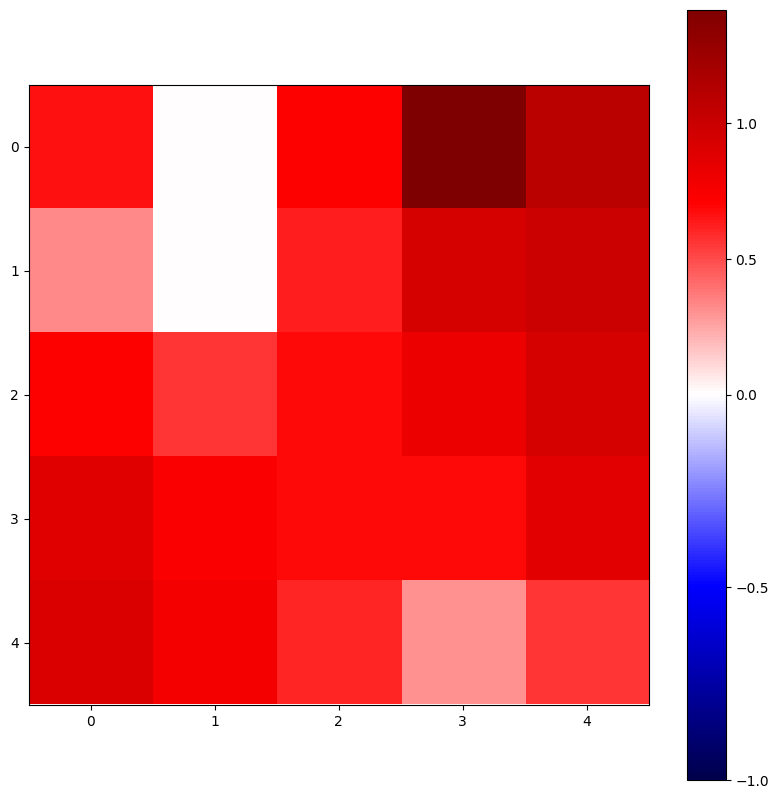

In [129]:
# Set deformation field from result
z_field = np.zeros(fixed_sample.shape)
def_field = np.stack([z_field, y_field, x_field], axis=0)
print(def_field.shape)

# Calculate the Jacobian determinant
jacobian_det = jacobian.sitk_jacobian_determinant(def_field)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))

# Create a custom colormap with white at zero
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det.min(), -1), vcenter=0, vmax=jacobian_det.max())

print("Jacobian det at 0, 1, 1:", jacobian_det[0, 1, 1])
print("Jacobian det at 0, 0, 1:", jacobian_det[0, 0, 1])

plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.show()
